In [1]:
# Importing libraries and modules
import Pkg; Pkg.activate("..")
using Pkg; Pkg.instantiate()
include("clippedSDE.jl")
using .clippedSDE, Plots, Statistics, Distributions, KernelDensity, StatsBase

  Activating project at `~/Documents/Bachelor Thesis Stuff`
  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


### Biochemical Reaction Kinetics

$$ 
\begin{align}
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{more Biomass X}, \\
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{Product Y}.
\end{align}
$$

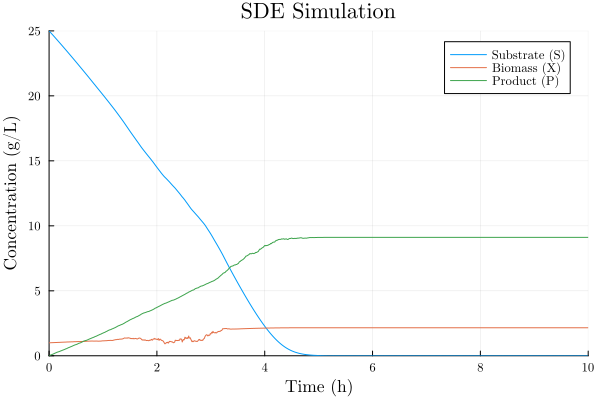

In [68]:
# Setting up the model parameters
# The parameters are defined in a dictionary for easy access and modification
params  = Dict(
    "μ_max" => 0.244, 
    "K_sx" => 11.5, 
    "Y_xs" => 0.28,
    "Y_ys" => 0.42,
    "m_s" => 0.015,
    "q_max_y" => 1.79,
    "K_sy" => 1.68,
    "σs" => 4.0,
    "σx" => 4.0,
    "σy" => 4.0
)

# Initial conditions for the state variables
# The initial conditions are defined in a dictionary for easy access and modification
init = Dict(
    "S0" => 25.0, 
    "X0" => 1.0, 
    "Y0" => 0,
)

# Time parameters
T = 10.0  # Time span for the simulation
dt = 0.01  # Time step for the simulation
N = Int(T / dt)  # Number of time steps
tsteps = 0:dt:T  # Time steps array

# Running the Monte Carlo simulation
M = 100  # Number of Monte Carlo simulations
sol = simulate_paths(params, T, init, M, dt)

# Storing the results in matrices for each state variable
S = zeros(length(sol), length(sol[1].t))
X = zeros(length(sol), length(sol[1].t))
Y = zeros(length(sol), length(sol[1].t))

for i in 1:length(sol)
    S[i, :] = sol[i][1, :]
    X[i, :] = sol[i][2, :]
    Y[i, :] = sol[i][3, :]
end

# Plotting the results
plot(sol[53], title="SDE Simulation", label=["Substrate (S)" "Biomass (X)" "Product (P)"], xlabel="Time (h)", ylabel="Concentration (g/L)")
plot!(legend=:topright, fontfamily="Computer Modern", lw=2, markersize=4, grid=true, ylims=(0, init["S0"]), xlims=(0, 10))